In [1]:
#@title Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Load data
macro_df = pd.read_csv("/content/drive/MyDrive/macro_features.csv", index_col="Date", parse_dates=True)
macro_df.head()

,CPI,Unemployment,10Y_Treasury,FedFundsRate,IP_Index,GDP_Growth,Inflation,Lending_Rate
Date,,,,,,,,
2010-01-31,217.488,9.8,3.73,0.11,89.1897,4.097918,-0.728243,1.598333
2010-02-28,217.281,9.8,3.69,0.13,89.5046,4.097918,-0.728243,1.598333
2010-03-31,217.353,9.9,3.73,0.16,90.1356,4.097918,-0.728243,1.598333
2010-04-30,217.403,9.9,3.85,0.20,90.4607,4.097918,-0.728243,1.598333
2010-05-31,217.290,9.6,3.42,0.20,91.7014,4.097918,-0.728243,1.598333


In [4]:
summary = macro_df.describe().T
summary["missing_values"] = macro_df.isnull().sum()
summary["first_valid"] = macro_df.apply(pd.Series.first_valid_index)
summary["last_valid"] = macro_df.apply(pd.Series.last_valid_index)
summary

,count,mean,std,min,25%,50%,75%,max,missing_values,first_valid,last_valid
CPI,96.0,233.047521,8.254241,217.199000,227.687250,234.733000,238.021000,247.805000,0,2010-01-31,2017-12-31
Unemployment,96.0,6.830208,1.854617,4.100000,5.000000,6.700000,8.350000,9.900000,0,2010-01-31,2017-12-31
10Y_Treasury,96.0,2.375208,0.561826,1.500000,1.970000,2.300000,2.702500,3.850000,0,2010-01-31,2017-12-31
FedFundsRate,96.0,0.267813,0.304206,0.070000,0.090000,0.140000,0.265000,1.300000,0,2010-01-31,2017-12-31
IP_Index,96.0,98.084421,3.423619,89.189700,96.465900,98.830500,100.346250,103.615100,0,2010-01-31,2017-12-31
GDP_Growth,96.0,1.473446,1.191221,0.023810,0.639421,1.467689,1.757774,4.097918,0,2010-01-31,2017-12-31
Inflation,96.0,0.400215,1.001083,-0.728243,-0.163558,0.145487,0.561970,2.759227,0,2010-01-31,2017-12-31
Lending_Rate,96.0,1.276406,0.203085,0.994000,1.118312,1.261458,1.430854,1.598333,0,2010-01-31,2017-12-31


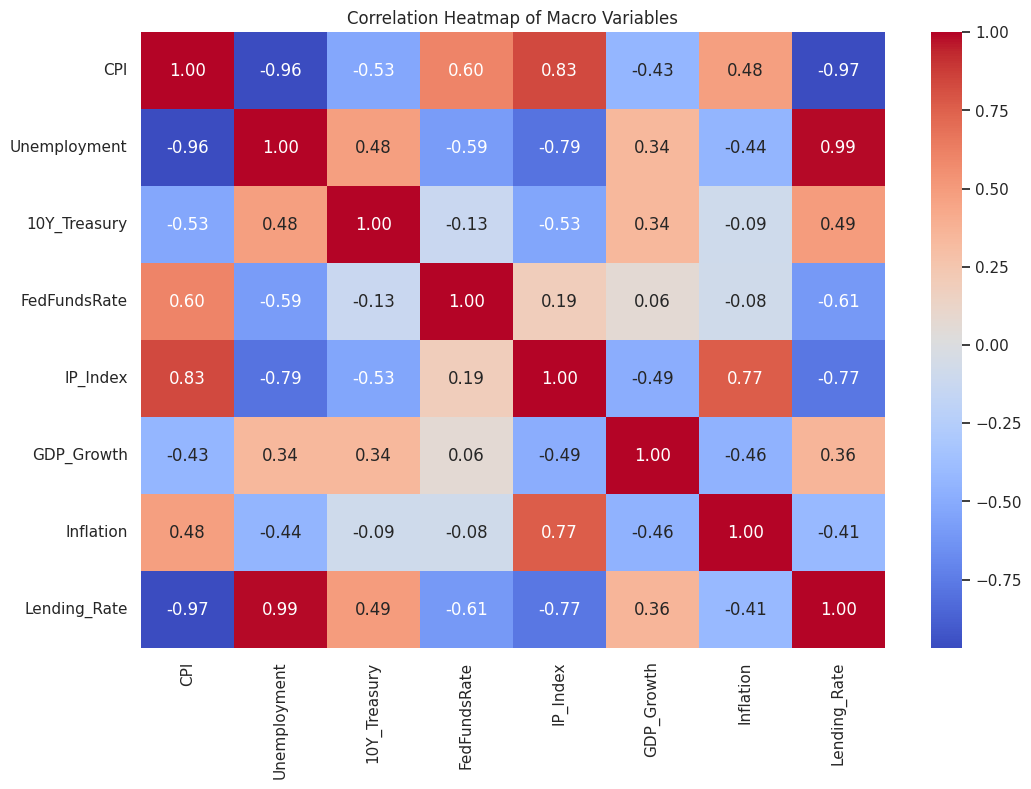

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(macro_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Macro Variables")
plt.show()

We begin with a simple correlation heatmap of the macro variables we've collected, which, reveals strong correaltions among several indicators. For instance, CPI and the Lending Rate are almost perfectly negatively correlated, while Unemployment and the Lending Rate exhibit a near-perfect positive correlation. Such strong interdependencies suggest that many variables move together, underscoring the risk of multicollinearity in direct modeling. We thus move on to PCA as a means to extract a smaller set of orthogonal factors that summarize the key sources of variation in the macroeconomic environment.

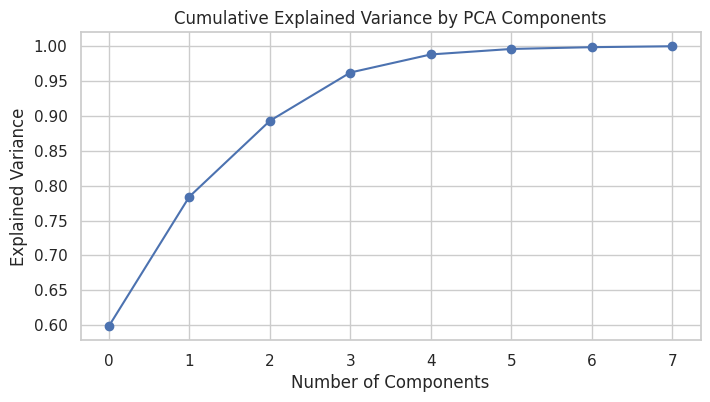

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(macro_df)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, index=macro_df.index, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
loadings = pd.DataFrame(pca.components_.T, index=macro_df.columns, columns=pca_df.columns)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

PCA was performed after following the standard procedure of Z-scoring each variable. In the scree plot, we observe that the first two principle components account for around 90% of the variance. This elbow suggests that most of the underlying structure in the data can be effectively summarized using just PC1 and PC2, providing a strong rationale for visualizing the data and factor loadings in two dimensions.

/tmp/ipython-input-7-4013333829.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, loadings["PC1"][i]*3, loadings["PC2"][i]*3, color='r', alpha=0.5)
/tmp/ipython-input-7-4013333829.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings["PC1"][i]*3.2, loadings["PC2"][i]*3.2, var, color='g', ha='center', va='center')


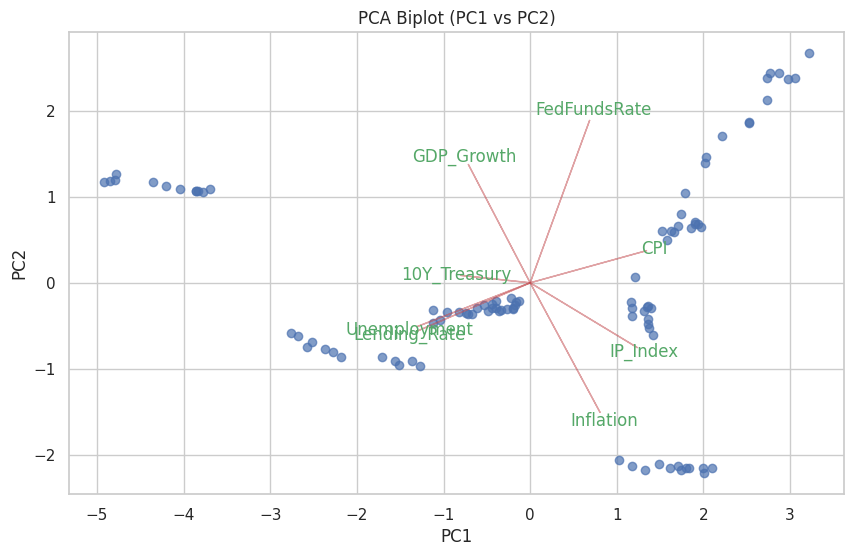

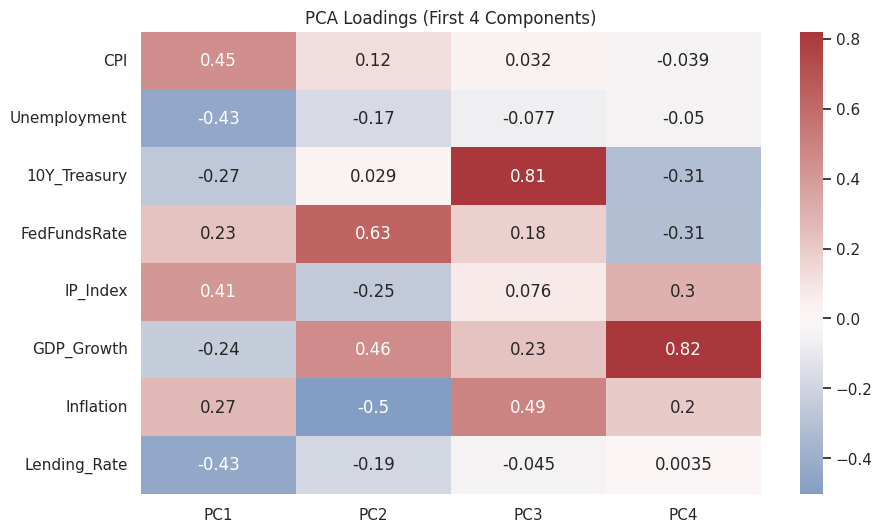

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7)
for i, var in enumerate(loadings.index):
    plt.arrow(0, 0, loadings["PC1"][i]*3, loadings["PC2"][i]*3, color='r', alpha=0.5)
    plt.text(loadings["PC1"][i]*3.2, loadings["PC2"][i]*3.2, var, color='g', ha='center', va='center')
plt.title("PCA Biplot (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :4], annot=True, cmap='vlag', center=0)
plt.title("PCA Loadings (First 4 Components)")
plt.show()

The biplot depicts the projection of our macroeconomic data onto the first two principal components. The overlaying arrows indicate the direction and strength of each original variable’s contribution. PC1 appears to capture a common growth or inflation factor, with variables like CPI, IP Index, and inflation loading positively. Unemployment and lending rate load negatively, which shows that PC1 likely reflects an overall economic activity cycle. PC2, on the other hand, is shaped most strongly by variables like Fed funds rate and GDP growth, indicating a possible policy or rate-sensitive dimension. This structure is reinforced by the heatmap of loadings, where we see that CPI, IP index, and inflation contribute positively to PC1, and lending rate and unemployment negatively, validating our interpretation. Meanwhile, PC3 and PC4 are dominated by the 10Y Treasury and GDP Growth respectively, suggesting these dimensions capture more specialized variations less correlated with the broad macro cycle.

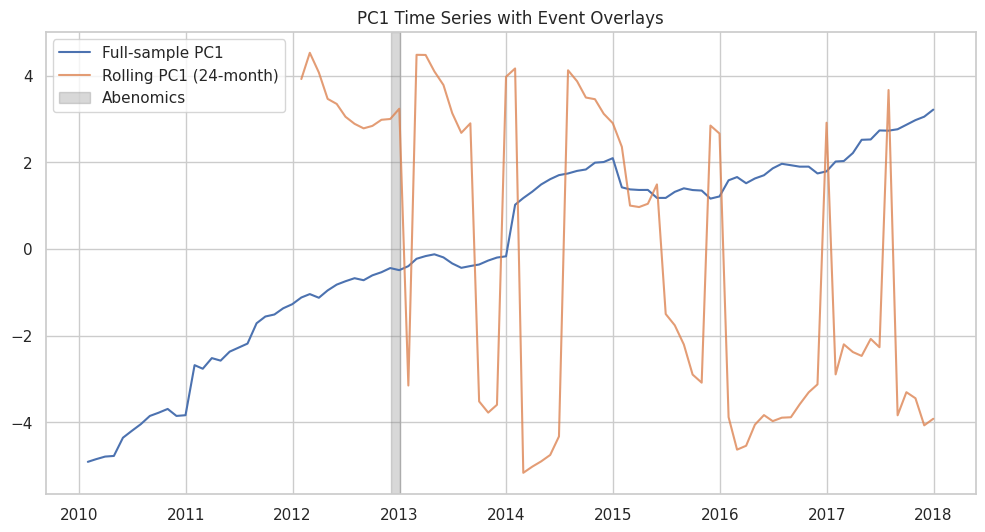

In [9]:
rolling_pca_scores = []
window = 24

for i in range(window, len(macro_df)):
    X_window = scaler.fit_transform(macro_df.iloc[i-window:i])
    pca_window = PCA(n_components=1)
    score = pca_window.fit_transform(X_window)[-1][0]
    rolling_pca_scores.append(score)

rolling_index = macro_df.index[window:]
rolling_pc1 = pd.Series(rolling_pca_scores, index=rolling_index)

plt.figure(figsize=(12, 6))
plt.plot(pca_df["PC1"], label="Full-sample PC1")
plt.plot(rolling_pc1, label="Rolling PC1 (24-month)", alpha=0.8)
plt.axvspan("2012-12", "2013-01", color='gray', alpha=0.3, label="Abenomics")
plt.legend()
plt.title("PC1 Time Series with Event Overlays")
plt.grid(True)
plt.show()

This plot tracks the evolution of PC1 over time, offering two perspectives: the blue line shows the PC1 scores from a full-sample PCA, while the orange line presents a 24-month rolling PCA, which re-estimates the factor using only a moving window of data. The full-sample PC1 shows a relatively smooth upward trend, likely reflecting a long-run macroeconomic cycle—possibly tied to sustained global growth. The rolling PC1, on the other hand, is much more volatile. This volatility indicates structural shifts in the correlation patterns among macro variables, with sudden jumps indicating moments when the dominant factor structure temporarily changed. For instance, we see major swings in the rolling PC1 around the launch of Abenomics in 2013 (highlighted in gray).

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

print("ADF:", adfuller(pca_df['PC1'])[1])
print("KPSS:", kpss(pca_df['PC1'], regression='c')[1])

ADF: 0.2615689175156648
KPSS: 0.01


/tmp/ipython-input-11-2684606620.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print("KPSS:", kpss(pca_df['PC1'], regression='c')[1])


We move on to ADF and KPSS tests in order to deepen our understanding of PC1. The ADF test - whose null hypothesis states the series is unit root - has p-value far greater than 0.05, and the KPSS test - whose null states that the series is stationary - is rejected at the 5% significance level. We thus conclude that PC1 is a non-stationary series whose mean and variance vary across time.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


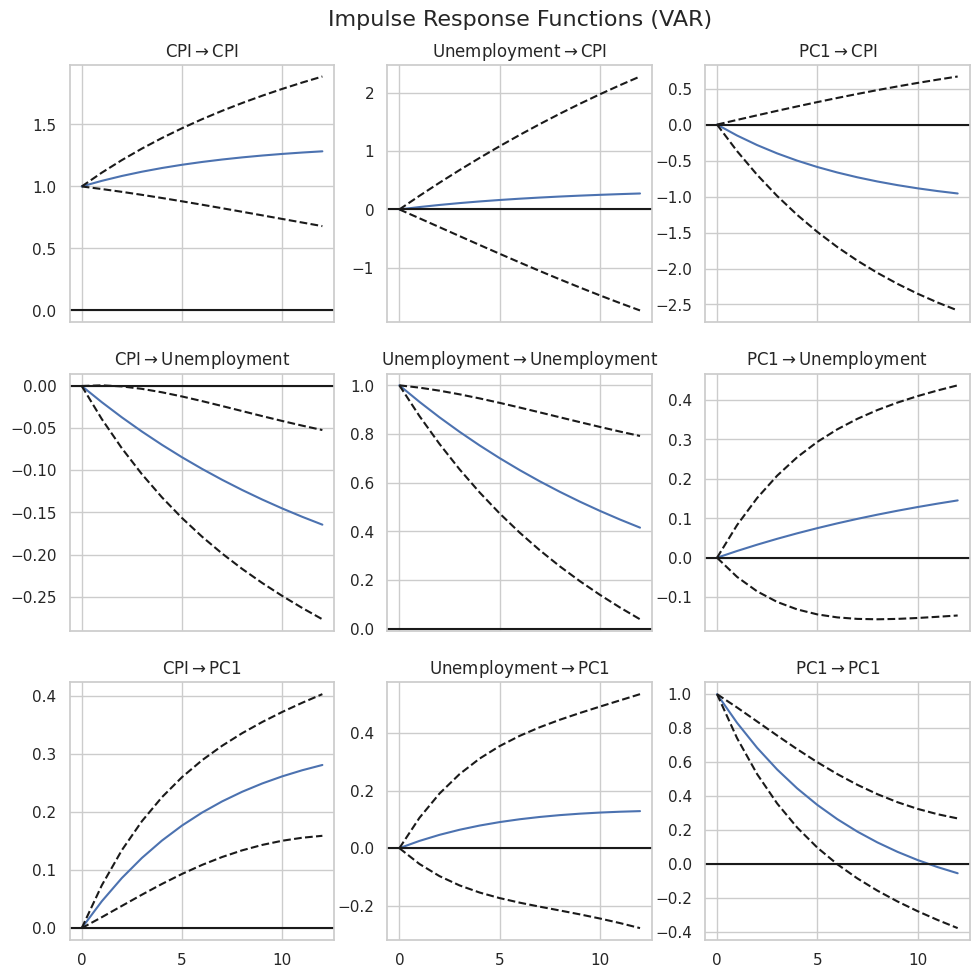

In [12]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

top_vars = loadings["PC1"].abs().sort_values(ascending=False).head(2).index.tolist()
var_df = macro_df[top_vars].copy()
var_df["PC1"] = pca_df["PC1"]
var_df = var_df.dropna()

model = VAR(var_df)
results = model.fit(maxlags=1)
irf = results.irf(12)

irf.plot(orth=False)
plt.suptitle("Impulse Response Functions (VAR)", fontsize=16)
plt.show()

These impulse response functions illustrate how shocks to one variable affect others over time in a VAR model including CPI, Unemployment, and PC1.

Starting with PC1 → CPI, we see a negative and persistent response. This suggests that PC1 may be capturing an underlying contractionary force—possibly linked to monetary tightening or reduced demand—that puts downward pressure on prices.

For PC1 → Unemployment, the response is positive. This suggests that PC1 captures broad economic conditions: a positive shock to PC1—interpreted as a deterioration in macro fundamentals—is followed by a rise in unemployment, consistent with labor market weakening.

CPI → PC1 is positive, indicating that an increase in consumer prices feeds into higher values of PC1, again supporting the view that PC1 aggregates general macroeconomic heating.

We see that this describes a causal chain like: CPI ↑ → PC1 ↑ → Unemployment ↑, which mirrors a classic macro narrative where inflationary pressures build, tightening follows, and unemployment rises.

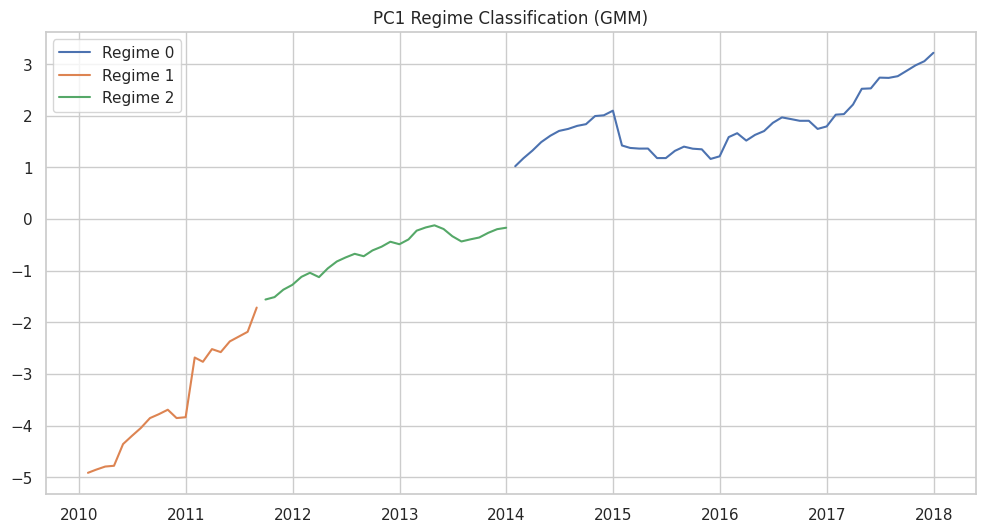

In [16]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)
regimes = gmm.fit_predict(pca_df[["PC1"]])
pca_df["Regime"] = regimes
macro_df['Regime'] = regimes

plt.figure(figsize=(12, 6))
for r in np.unique(regimes):
    plt.plot(pca_df[pca_df["Regime"] == r].index, pca_df["PC1"][pca_df["Regime"] == r], label=f"Regime {r}")
plt.legend()
plt.title("PC1 Regime Classification (GMM)")
plt.grid(True)
plt.show()

The chart shows regime classification over time for the PC1 using GMM. Each segment of the line is color-coded based on the regime it belongs to:

-Regime 1 (Orange): early 2010–mid 2011

-Regime 2 (Green): mid 2011–early 2014

-Regime 0 (Blue): mid 2014–2018

From the plot, we can make the following qualitative observations: Regime 1 is characterized by very low PC1 values, reflecting poor macro conditions. This likely corresponds to the post-global financial crisis recovery period, marked by slack demand, high unemployment, and accommodative monetary policy. Regime 2 represents a transition period. PC1 is still negative but begins to recover, which might correspond to initial signs of recovery or structural reforms like the early phases of Abenomics. Regime 0 sees consistently positive PC1 values, reflecting stronger macro conditions—this may represent an economic expansion period, possibly tied to improved inflation expectations, rising interest rates, and robust employment.

In [17]:
regime_summary = macro_df.groupby('Regime')[['CPI', 'Unemployment', 'Inflation', 'GDP_Growth', 'FedFundsRate']].mean()
print(regime_summary)

               CPI  Unemployment  Inflation  GDP_Growth  FedFundsRate
Regime                                                               
0       239.710792      5.166667   0.977862    1.071498      0.404583
1       220.412550      9.380000  -0.545928    2.468275      0.151000
2       230.649750      7.860714   0.085781    1.451909      0.116786


In [19]:
regime_labels = {1: 'Stagnation', 2: 'Recovery', 0: 'Expansion'}
macro_df['RegimeLabel'] = macro_df['Regime'].map(regime_labels)

In [20]:
print("Unemployment descending:",
      regime_summary['Unemployment'].loc[1] > regime_summary['Unemployment'].loc[2] > regime_summary['Unemployment'].loc[0])

print("Inflation ascending:",
      regime_summary['Inflation'].loc[1] < regime_summary['Inflation'].loc[2] < regime_summary['Inflation'].loc[0])

print("FedFundsRate ascending:",
      regime_summary['FedFundsRate'].loc[1] < regime_summary['FedFundsRate'].loc[2] < regime_summary['FedFundsRate'].loc[0])

print("GDP Growth ascending:",
      regime_summary['GDP_Growth'].loc[1] < regime_summary['GDP_Growth'].loc[2] < regime_summary['GDP_Growth'].loc[0])

print("CPI ascending:",
      regime_summary['CPI'].loc[1] < regime_summary['CPI'].loc[2] < regime_summary['CPI'].loc[0])

Unemployment descending: True
Inflation ascending: True
FedFundsRate ascending: False
GDP Growth ascending: False
CPI ascending: True


We attempt to quickly check that the regime labels are validated economically, and we see that the regime classifications are largely consistent with economic intuition. As we move from Regime 1 (Stagnation) to Regime 2 (Recovery) and then to Regime 0 (Expansion), unemployment steadily declines and both inflation and CPI increase, which supports the interpretation of improving macroeconomic conditions. However, two indicators - GDP growth and the Fed Funds Rate - do not follow the expected ascending pattern. GDP growth peaks in the intermediate regime (Recovery), possibly reflecting a temporary growth surge during structural reforms or post-crisis rebounds. Meanwhile, the Fed Funds Rate remains low even in the expansion regime, which could be attributed to prolonged accommodative monetary policy in the aftermath of the global financial crisis.

In [ ]:
pca_df["PC1"].to_csv("macro_factor.csv")
pca_df["Regime"].to_csv("macro_regime.csv")

In [11]:
#@title Export as CSV

from google.colab import files

files.download("macro_factor.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
files.download("macro_regime.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

### Objective  
In this notebook, we aimed to extract a dominant latent macroeconomic factor (PC1) from a panel of U.S.–Japan macroeconomic indicators and to analyze its structural properties, dynamic effects, and regime-specific behavior over time.

### Key Findings  
PC1 explains approximately 90% of the total variance in the macro dataset, suggesting it captures a common underlying economic force. Time-series tests (ADF and KPSS) confirm that PC1 is non-stationary, exhibiting persistent trends consistent with evolving macroeconomic conditions. VAR-based impulse response functions reveal that shocks to PC1 are associated with higher unemployment and lower inflation, consistent with a contractionary macro dynamic.

Using Gaussian Mixture Models, we identified three distinct regimes—interpreted as Stagnation, Recovery, and Expansion, each aligning well with observable macroeconomic indicators. Quantitative validation confirmed that unemployment declines and inflation rises across the regimes in economically consistent directions, supporting the interpretability and robustness of the classification.

### Implications  
PC1 provides a compact and interpretable summary of macroeconomic comovement. The regime structure derived from PC1 can be used to inform portfolio allocation strategies, or behavioral rule design in agent-based macroeconomic models.

### Next Steps  
We will develop a differentiable agent-based model that jointly learns agent behavior and macro dynamics. The ABM will be supervised using macro_factor.csv and macro_regime.csv, allowing simultaneous optimization of agent parameters and the predictive accuracy of an embedded LSTM. This setup enables the model to capture regime-dependent heterogeneity in economic behavior while improving out-of-sample macroeconomic forecasting.
